## Классификация RUL 
(Ноутбук для классических алгоритмов)

TO DO:
- LogReg
- Random Forest
- Gradient Boosting (sklearn, xgboost, catboost)

#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from PIL import Image
import itertools
from time import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array

import warnings
warnings.filterwarnings("ignore")

C:\Users\I519322\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Чтение данных

In [2]:
df = pd.read_parquet('data/train_data.parquet', engine='fastparquet')

In [3]:
test = pd.read_parquet('data/test_data.parquet')

In [4]:
df_feat = pd.read_parquet('data/train_data_feat.parquet')

In [5]:
test_feat = pd.read_parquet('data/test_data_feat.parquet')

Отшкалируем данные

In [6]:
# params = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
#        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
#        's15', 's16', 's17', 's18', 's19', 's20', 's21']

params = ['setting1', 'setting2', 's2', 's3', 's4', 's7', 
          's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 
          's20', 's21']
          
# параметры отобранные случайным лесом
feat_imp = pd.read_parquet('data/feature_imp_class.parquet')
params_imp = feat_imp.feature[:100]

In [7]:
scaler = StandardScaler()

df_feat[params_imp] = scaler.fit_transform(df_feat[params_imp])

In [8]:
test_feat[params_imp] = scaler.fit_transform(test_feat[params_imp])

In [9]:
df[params] = scaler.fit_transform(df[params])
test[params] = scaler.fit_transform(test[params])

In [10]:
xtrain = df[params]
ytrain = df['label']
xtest = test[params]
ytest = test['label']

xtrain_feat = df_feat[params_imp]
ytrain = df['label']
xtest_feat = test_feat[params_imp]
ytest = test['label']

#### Функции для отрисовки

In [11]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

#### Логистическая регрессия

In [23]:
model_lg = LogisticRegression(solver='saga',
                          multi_class='multinomial',
#                           class_weight={0:1,1:1.2,2:2.5},
                          max_iter=1000,
                          penalty='l2',
                          n_jobs=4)

model_lg.fit(xtrain, ytrain)

y_pred_lg = model_lg.predict(xtest)

print(classification_report(ytest, y_pred_lg))

              precision    recall  f1-score   support

           0       0.99      0.82      0.89     11856
           1       0.23      0.55      0.33      1180
           2       0.11      1.00      0.21        60

    accuracy                           0.79     13096
   macro avg       0.44      0.79      0.47     13096
weighted avg       0.92      0.79      0.84     13096



In [24]:
confusion_matrix(ytest, y_pred_lg)

array([[9672, 2138,   46],
       [ 117,  644,  419],
       [   0,    0,   60]], dtype=int64)

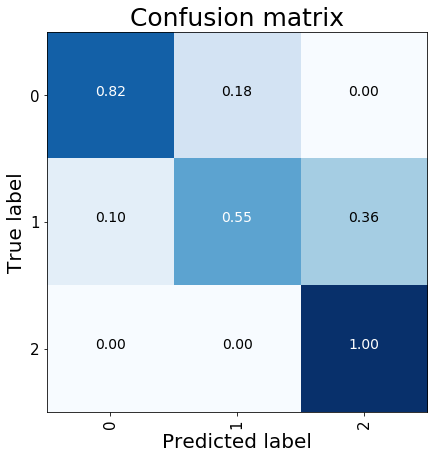

In [27]:
cnf_matrix = confusion_matrix(ytest, y_pred_lg)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2], title="Confusion matrix")
plt.show()

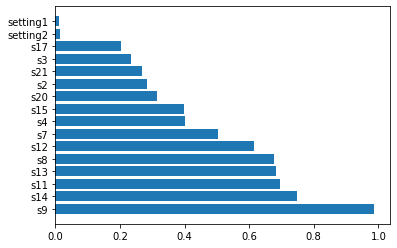

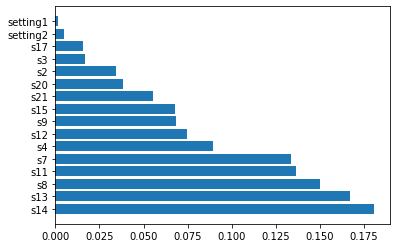

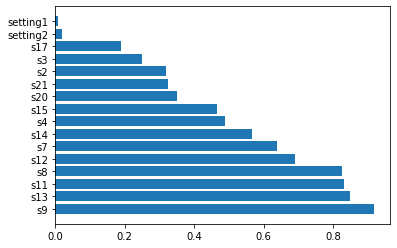

In [63]:
lg_feat=pd.DataFrame({'feature':xtrain.columns, 
                     'imp_0':abs(model_lg.coef_[0]),
                     'imp_1':abs(model_lg.coef_[1]),
                     'imp_2':abs(model_lg.coef_[2])})
plt.barh(lg_feat.sort_values(['imp_0'], ascending=False).feature[:20],
         lg_feat.sort_values(['imp_0'], ascending=False).imp_0[:20])
plt.show()
plt.barh(lg_feat.sort_values(['imp_1'], ascending=False).feature[:20],
         lg_feat.sort_values(['imp_1'], ascending=False).imp_1[:20])
plt.show()
plt.barh(lg_feat.sort_values(['imp_2'], ascending=False).feature[:20],
         lg_feat.sort_values(['imp_2'], ascending=False).imp_2[:20])
plt.show()

In [28]:
model_lg_feat = LogisticRegression(solver='saga',
                          multi_class='multinomial',
                          max_iter=1000,
#                           class_weight={0:1,1:2,2:4},
                          penalty='l2',
                          n_jobs=4)

model_lg_feat.fit(xtrain_feat, ytrain)

y_pred_lg_feat = model_lg_feat.predict(xtest_feat)

print(classification_report(ytest, y_pred_lg_feat))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87     11856
           1       0.25      0.76      0.38      1180
           2       0.22      1.00      0.36        60

    accuracy                           0.77     13096
   macro avg       0.49      0.84      0.53     13096
weighted avg       0.92      0.77      0.82     13096



In [29]:
confusion_matrix(ytest, y_pred_lg_feat)

array([[9176, 2674,    6],
       [  75,  895,  210],
       [   0,    0,   60]], dtype=int64)

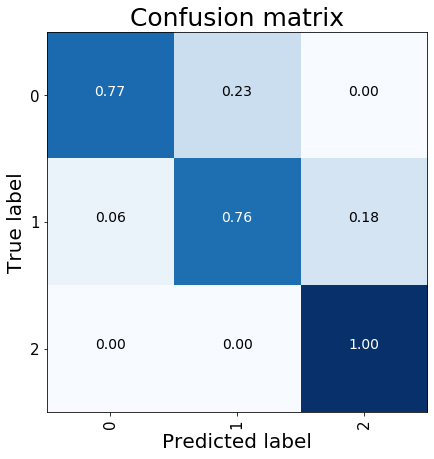

In [30]:
cnf_matrix = confusion_matrix(ytest, y_pred_lg_feat)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2], title="Confusion matrix")
plt.show()

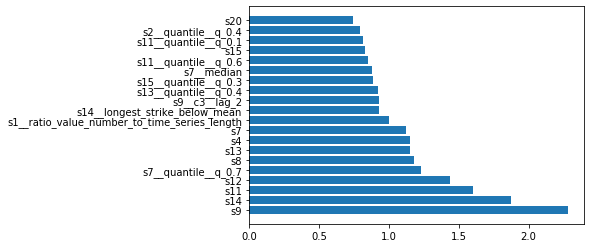

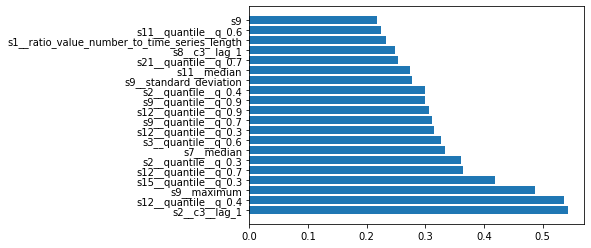

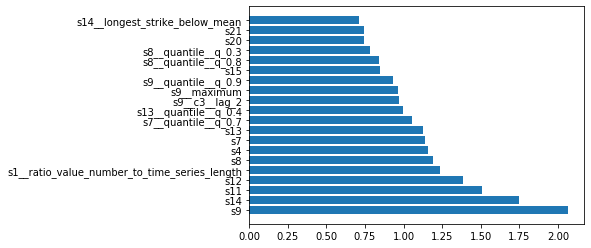

In [53]:
lg_feat=pd.DataFrame({'feature':xtrain_feat.columns, 
                     'imp_0':abs(model_lg_feat.coef_[0]),
                     'imp_1':abs(model_lg_feat.coef_[1]),
                     'imp_2':abs(model_lg_feat.coef_[2])})
plt.barh(lg_feat.sort_values(['imp_0'], ascending=False).feature[:20],
         lg_feat.sort_values(['imp_0'], ascending=False).imp_0[:20])
plt.show()
plt.barh(lg_feat.sort_values(['imp_1'], ascending=False).feature[:20],
         lg_feat.sort_values(['imp_1'], ascending=False).imp_1[:20])
plt.show()
plt.barh(lg_feat.sort_values(['imp_2'], ascending=False).feature[:20],
         lg_feat.sort_values(['imp_2'], ascending=False).imp_2[:20])
plt.show()

#### Случайный лес

In [54]:
model_rf = RandomForestClassifier(n_estimators=300,
                                  bootstrap=False,
                                  max_depth=4,
                                  n_jobs=4)

model_rf.fit(xtrain, ytrain)

y_pred_rf = model_rf.predict(xtest)

print(classification_report(ytest, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.82      0.89     11856
           1       0.25      0.60      0.35      1180
           2       0.13      1.00      0.23        60

    accuracy                           0.80     13096
   macro avg       0.46      0.81      0.49     13096
weighted avg       0.92      0.80      0.84     13096



In [55]:
confusion_matrix(ytest, y_pred_rf)

array([[9697, 2107,   52],
       [ 128,  705,  347],
       [   0,    0,   60]], dtype=int64)

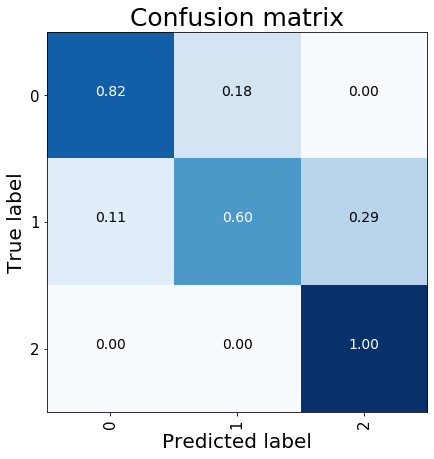

In [56]:
cnf_matrix = confusion_matrix(ytest, y_pred_rf)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2], title="Confusion matrix")
plt.show()

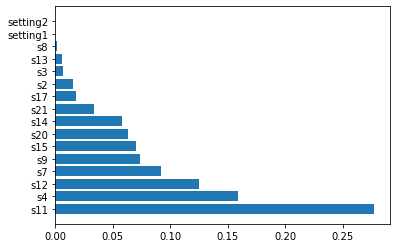

In [64]:
lg_feat=pd.DataFrame({'feature':xtrain.columns, 
                     'importance': model_rf.feature_importances_})
plt.barh(lg_feat.sort_values(['importance'], ascending=False).feature[:20],
         lg_feat.sort_values(['importance'], ascending=False).importance[:20])
plt.show()

In [57]:
model_rf_feat = RandomForestClassifier(n_estimators=50,
                                      n_jobs=4)

model_rf_feat.fit(xtrain_feat, ytrain)

y_pred_rf_feat = model_rf_feat.predict(xtest_feat)

print(classification_report(ytest, y_pred_rf_feat))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     11856
           1       0.26      0.68      0.38      1180
           2       0.15      1.00      0.26        60

    accuracy                           0.80     13096
   macro avg       0.47      0.83      0.51     13096
weighted avg       0.93      0.80      0.84     13096



In [58]:
confusion_matrix(ytest, y_pred_rf_feat)

array([[9585, 2264,    7],
       [  41,  804,  335],
       [   0,    0,   60]], dtype=int64)

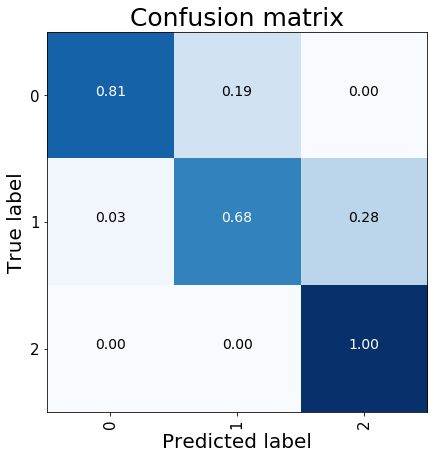

In [59]:
cnf_matrix = confusion_matrix(ytest, y_pred_rf_feat)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2], title="Confusion matrix")
plt.show()

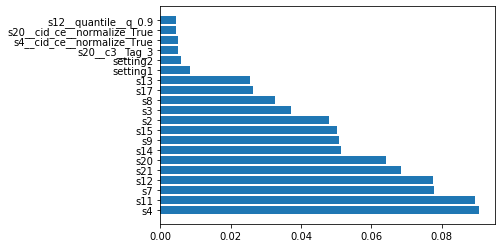

In [61]:
lg_feat=pd.DataFrame({'feature':xtrain_feat.columns, 
                     'importance': model_rf_feat.feature_importances_})
plt.barh(lg_feat.sort_values(['importance'], ascending=False).feature[:20],
         lg_feat.sort_values(['importance'], ascending=False).importance[:20])
plt.show()

#### Градиентный бустинг

In [110]:
model_xgb = XGBClassifier(max_depth=4,
                    learning_rate=0.05,
                    objective='multi:softmax',
                    n_jobs=-1,
                    booster='gbtree', 
                    n_estimators=100, 
                    num_class=3)

model_xgb.fit(xtrain, ytrain)
y_pred_xgb = model_xgb.predict(xtest)

print(classification_report(ytest, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88     11856
           1       0.22      0.56      0.32      1180
           2       0.11      1.00      0.20        60

    accuracy                           0.78     13096
   macro avg       0.44      0.79      0.47     13096
weighted avg       0.92      0.78      0.83     13096



In [111]:
confusion_matrix(ytest, y_pred_xgb)

array([[9463, 2336,   57],
       [ 108,  663,  409],
       [   0,    0,   60]], dtype=int64)

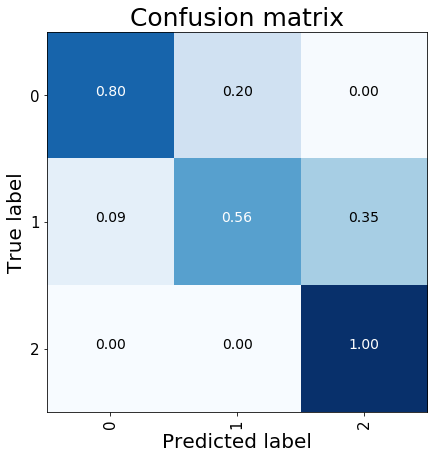

In [112]:
cnf_matrix = confusion_matrix(ytest, y_pred_xgb)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2], title="Confusion matrix")
plt.show()

In [105]:
model_xgb_feat = XGBClassifier(learning_rate=0.05,
                    n_jobs=-1, 
                    n_estimators=150)

model_xgb_feat.fit(xtrain_feat, ytrain)
y_pred_xgb_feat = model_xgb_feat.predict(xtest_feat)

print(classification_report(ytest, y_pred_xgb_feat))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     11856
           1       0.25      0.63      0.36      1180
           2       0.12      1.00      0.21        60

    accuracy                           0.79     13096
   macro avg       0.45      0.81      0.49     13096
weighted avg       0.93      0.79      0.84     13096



In [106]:
confusion_matrix(ytest, y_pred_xgb_feat)

array([[9569, 2257,   30],
       [  23,  743,  414],
       [   0,    0,   60]], dtype=int64)

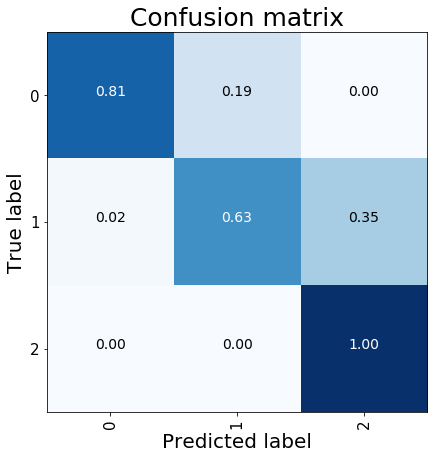

In [107]:
cnf_matrix = confusion_matrix(ytest, y_pred_xgb_feat)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2], title="Confusion matrix")
plt.show()

In [117]:
model_gb = GradientBoostingClassifier(learning_rate=0.01,
                                        n_estimators=100)

model_gb.fit(xtrain, ytrain)
y_pred_gb = model_gb.predict(xtest)

print(classification_report(ytest, y_pred_gb))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93     11856
           1       0.33      0.54      0.41      1180
           2       0.13      0.98      0.23        60

    accuracy                           0.86     13096
   macro avg       0.48      0.80      0.52     13096
weighted avg       0.92      0.86      0.88     13096



In [118]:
confusion_matrix(ytest, y_pred_gb)

array([[10524,  1285,    47],
       [  196,   639,   345],
       [    0,     1,    59]], dtype=int64)

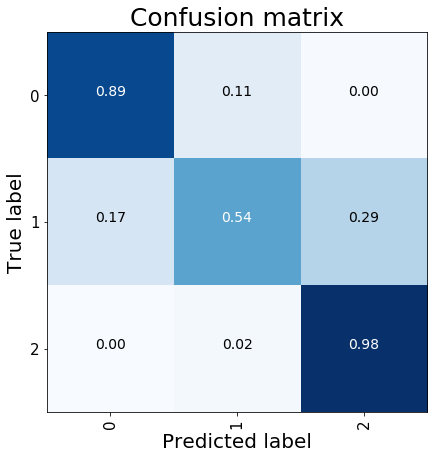

In [119]:
cnf_matrix = confusion_matrix(ytest, y_pred_gb)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2], title="Confusion matrix")
plt.show()

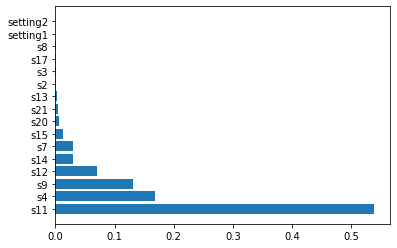

In [122]:
lg_feat=pd.DataFrame({'feature':xtrain.columns, 
                     'importance': model_gb.feature_importances_})
plt.barh(lg_feat.sort_values(['importance'], ascending=False).feature[:20],
         lg_feat.sort_values(['importance'], ascending=False).importance[:20])
plt.show()

In [125]:
model_gb_feat = GradientBoostingClassifier(learning_rate=0.01,
                                        n_estimators=100)

model_gb_feat.fit(xtrain_feat, ytrain)
y_pred_gb_feat = model_gb_feat.predict(xtest_feat)

print(classification_report(ytest, y_pred_gb_feat))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     11856
           1       0.36      0.56      0.44      1180
           2       0.13      1.00      0.23        60

    accuracy                           0.87     13096
   macro avg       0.49      0.82      0.54     13096
weighted avg       0.92      0.87      0.89     13096



In [126]:
confusion_matrix(ytest, y_pred_gb_feat)

array([[10626,  1186,    44],
       [  165,   661,   354],
       [    0,     0,    60]], dtype=int64)

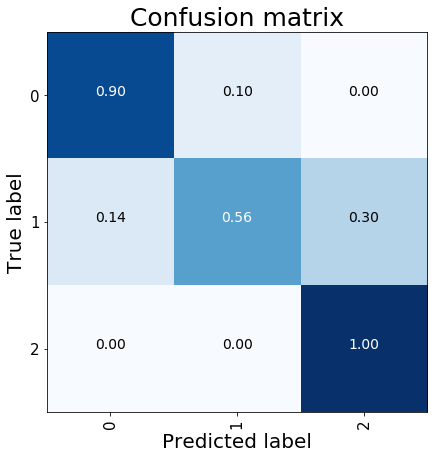

In [127]:
cnf_matrix = confusion_matrix(ytest, y_pred_gb_feat)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2], title="Confusion matrix")
plt.show()

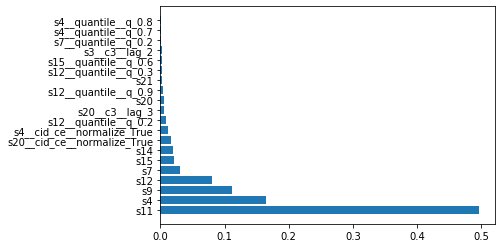

In [128]:
lg_feat=pd.DataFrame({'feature':xtrain_feat.columns, 
                     'importance': model_gb_feat.feature_importances_})
plt.barh(lg_feat.sort_values(['importance'], ascending=False).feature[:20],
         lg_feat.sort_values(['importance'], ascending=False).importance[:20])
plt.show()

In [79]:
model_cat = CatBoostClassifier(learning_rate=0.05,
                                max_depth=4,
                                n_estimators=150,
                               l2_leaf_reg=3,
                               custom_metric=['Precision', 'Recall', 'F1','MultiClass'],
                                verbose=0)
# model_cat = CatBoostClassifier(learning_rate=0.05,
#                                 max_depth=4,
#                                 n_estimators=150,
# #                                 l2_leaf_reg=3,
#                                custom_metric=['Precision', 'Recall', 'F1','MultiClass'],
#                                 verbose=0)
model_cat.fit(xtrain, ytrain, plot=True)
y_pred_cat = model_cat.predict(xtest)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [80]:
print(classification_report(ytest, y_pred_cat))

              precision    recall  f1-score   support

           0       0.99      0.78      0.87     11856
           1       0.21      0.58      0.31      1180
           2       0.12      1.00      0.21        60

    accuracy                           0.76     13096
   macro avg       0.44      0.79      0.47     13096
weighted avg       0.92      0.76      0.82     13096



In [81]:
confusion_matrix(ytest, y_pred_cat)

array([[9257, 2551,   48],
       [  99,  685,  396],
       [   0,    0,   60]], dtype=int64)

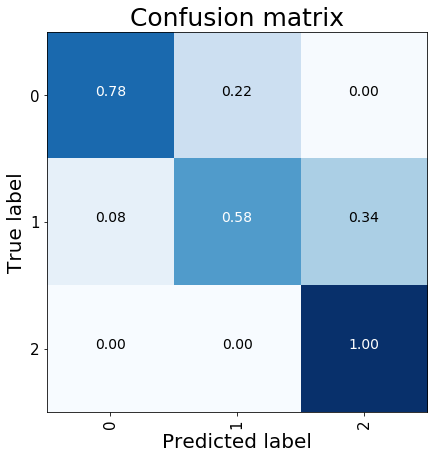

In [82]:
cnf_matrix = confusion_matrix(ytest, y_pred_cat)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2], title="Confusion matrix")
plt.show()

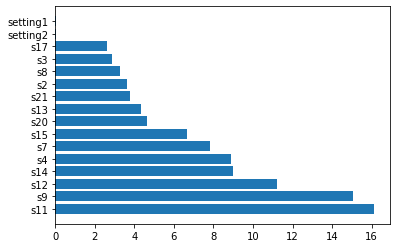

In [83]:
lg_feat=pd.DataFrame({'feature':xtrain.columns, 
                     'importance': model_cat.feature_importances_})
plt.barh(lg_feat.sort_values(['importance'], ascending=False).feature[:20],
         lg_feat.sort_values(['importance'], ascending=False).importance[:20])
plt.show()

In [84]:
model_cat_feat = CatBoostClassifier(learning_rate=0.05,
                                max_depth=4,
                                n_estimators=150,
                                l2_leaf_reg=3,
                               custom_metric=['Precision', 'Recall', 'F1','MultiClass'],
                                verbose=0)
model_cat_feat.fit(xtrain_feat, ytrain, plot=True)
y_pred_cat_feat = model_cat_feat.predict(xtest_feat)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [85]:
print(classification_report(ytest, y_pred_cat_feat))

confusion_matrix(ytest, y_pred_cat_feat)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     11856
           1       0.25      0.67      0.37      1180
           2       0.14      1.00      0.24        60

    accuracy                           0.79     13096
   macro avg       0.46      0.82      0.50     13096
weighted avg       0.93      0.79      0.84     13096



array([[9484, 2360,   12],
       [  18,  794,  368],
       [   0,    0,   60]], dtype=int64)

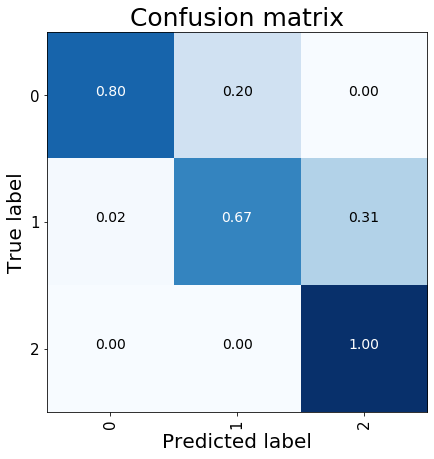

In [86]:
cnf_matrix = confusion_matrix(ytest, y_pred_cat_feat)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2], title="Confusion matrix")
plt.show()

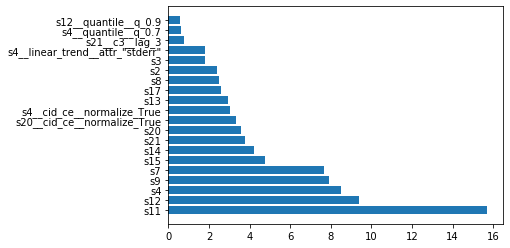

In [87]:
lg_feat=pd.DataFrame({'feature':xtrain_feat.columns, 
                     'importance': model_cat_feat.feature_importances_})
plt.barh(lg_feat.sort_values(['importance'], ascending=False).feature[:20],
         lg_feat.sort_values(['importance'], ascending=False).importance[:20])
plt.show()

#### Приложение

In [8]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [21]:
def plot_confusion_matrix1(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [1]:
def plot_confusion_matrix2(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()